In [1]:
from __future__ import print_function

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import graphviz

import pandas as pd
import neat
import numpy as np
import pickle

import copy
import warnings
warnings.filterwarnings('ignore')

# Data init

In [37]:
# heart
dataset = pd.read_csv('heart.csv', header=None, sep=',', engine='python')
dataset = dataset.drop(labels=[3,4,5,6], axis=1)
names = dataset.iloc[0, :]
dataset = dataset.drop([0])
dataset = dataset.astype(float)
inputs = dataset.iloc[:, 0:(13-4)].values
outputs = dataset.iloc[:, (13-4)].values
inputs = np.array(inputs)
outputs = np.array(outputs)
config_path = 'config'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path)

In [109]:
dataset = pd.read_csv('heart.csv', header=None, sep=',', engine='python')
dataset = dataset.drop(labels=[3,4,5,6], axis=1)
dataset.columns = dataset.loc[0].values
dataset = dataset.drop([0])
dataset.head()

,age,sex,cp,thalachh,exng,oldpeak,slp,caa,thall,output
1,63,1,3,150,0,2.3,0,0,1,1
2,37,1,2,187,0,3.5,0,0,2,1
3,41,0,1,172,0,1.4,2,0,2,1
4,56,1,1,178,0,0.8,2,0,2,1
5,57,0,0,163,1,0.6,2,0,2,1


# Ops

### eval_genomes

In [38]:
def eval_genomes(genomes,config):
    for genome_id, genome in genomes:
        genome.fitness = len(inputs)
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(inputs, outputs):
            output = net.activate(xi)
            #use threshold
            output = 1 if output[0] > 0.5 else 0
            genome.fitness -= (output - xo) ** 2

### launch

In [39]:
def launch(generations = 300):
    p = neat.Population(config)
    # Add a stdout reporter to show progress in the terminal.
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    winner = p.run(eval_genomes, generations)
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    calculate_metrics(winner_net, inputs, outputs)
    plot_stats(stats, ylog=False, view=True)
    return winner

### calculate_metrics

In [40]:
def calculate_metrics(winner_net, inputs, outputs):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for xi, xo in zip(inputs, outputs):
        output = winner_net.activate(xi)
        output = 1 if output[0] > 0.5 else 0
        if output == 1 and xo == 1:
            TP += 1
        elif output == 0 and xo == 0:
            TN += 1
        elif output == 1 and xo == 0:
            FP += 1
        elif output == 0 and xo == 1:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    F1 = TP / (TP + 0.5*(FP + FN))
    
    print("Confusion matrix:")
    print(TP, ' ', FP)
    print(FN, ' ', TN, '\n')

    print("accuracy: ", accuracy)
    print("F1: ", F1)  

### plot_the_graph

In [41]:
def plot_the_graph(winner):
    list_of_nodes = []
    for node in winner.connections.values():
        temp = []
        for neuron in node.key:
            temp.append(neuron)
        temp.append(node.weight)
        list_of_nodes.append(temp)
    
    unique_nodes = []
    for node in list_of_nodes:
        if node[0] not in unique_nodes:
            unique_nodes.append(node[0])
        if node[1] not in unique_nodes:
            unique_nodes.append(node[1])
    
    G = nx.DiGraph()
    i_neg = 0
    i_pos = 0
    for node in unique_nodes:
        if node > 0:
            G.add_node(node, pos=(1, i_pos ))
            i_pos += 2
        elif node < 0:
            G.add_node(node, pos=(0, i_neg))
            i_neg += 2
        else:
            G.add_node(node, pos=(2, 5))

    for node in list_of_nodes:
        G.add_edge(node[0], node[1], weight=node[2])

    # positions of the nodes
    pos = nx.get_node_attributes(G, 'pos')

    # color the arrows
    edge_colors = ['r' if G[u][v]['weight'] < 0 else 'g' for u,v in G.edges()]
    # green for input nodes, yellow for hidden nodes, red for output nodes
    node_colors = ['gray' if node < 0 else 'y' if node > 0 else 'pink' for node in G.nodes()]

    # weights of the edges
    weights = nx.get_edge_attributes(G, 'weight')
    # draw the graph
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, node_size=500, arrows=True)
    plt.show()

In [42]:
def calculate_metrics(winner_net, inputs, outputs):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for xi, xo in zip(inputs, outputs):
        output = winner_net.activate(xi)
        output = 1 if output[0] > 0.5 else 0
        #print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))    
        if output == 1 and xo == 1:
            TP += 1
        elif output == 0 and xo == 0:
            TN += 1
        elif output == 1 and xo == 0:
            FP += 1
        elif output == 0 and xo == 1:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    F1 = TP / (TP + 0.5*(FP + FN))
    
    print("Confusion matrix:")
    print(TP, ' ', FP)
    print(FN, ' ', TN, '\n')

    print("accuracy: ", accuracy)
    print("F1: ", F1)  

### plot_stats

In [44]:
def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()

### Save_load

In [43]:
def save_model(model, path):
    with open(path, 'wb') as output:
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def load_model(path):
    with open(path, 'rb') as input:
        model = pickle.load(input)
    return model

# Leeego

### Neat apply

Confusion matrix:
148   32
17   106 

accuracy:  0.8382838283828383
F1:  0.8579710144927536


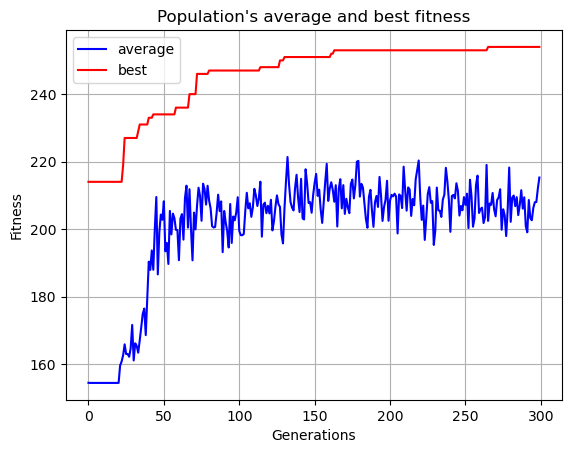

Wall time: 2min 16s


In [46]:
%%time
winner = launch(generations = 300)

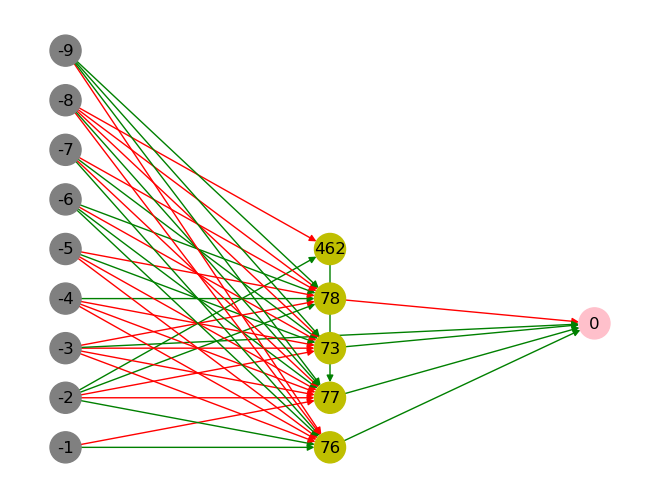

In [47]:
plot_the_graph(winner)

In [13]:
node_names = {-n:names.values[-1+n] for n in range(len(names))}
node_names

{0: 'output',
 -1: 'age',
 -2: 'sex',
 -3: 'cp',
 -4: 'thalachh',
 -5: 'exng',
 -6: 'oldpeak',
 -7: 'slp',
 -8: 'caa',
 -9: 'thall'}

In [93]:
save_model(winner, 'models/best_heart_drop_final_2.pkl')

In [111]:
#winner = load_model( 'models/best_heart_drop_final_2.pkl')

-------------------

### Debug

In [83]:
list_of_nodes = []
for node in winner.connections.values():
    temp = []
    for neuron in node.key:
        temp.append(neuron)
    temp.append(node.weight)
    list_of_nodes.append(temp)

In [84]:
def clean(list_of_nodes):
    for node in list_of_nodes:
        if node[0] > 0 and node[1] > 0:
            # pop the node
            print(node)
            list_of_nodes.remove(node)
    return list_of_nodes

In [85]:
list_of_nodes = clean(list_of_nodes)
list_of_nodes = clean(list_of_nodes)
list_of_nodes.remove(list_of_nodes[-1])
list_of_nodes.remove(list_of_nodes[-1])

[462, 77, 0.9322988724724448]


In [86]:
list_of_nodes

[[-1, 76, 0.7055140654967621],
 [-1, 77, -3.4656348373494112],
 [-2, 73, -1.1305832500523554],
 [-2, 76, 0.1871794481160508],
 [-2, 77, -2.0810589457640685],
 [-2, 78, 0.485032505724866],
 [-3, 73, -1.0471732992708245],
 [-3, 76, -0.6590803696380411],
 [-3, 77, -0.6698209462641136],
 [-3, 78, -1.0767231184501052],
 [-4, 73, -1.7895492397689492],
 [-4, 76, -1.6756936642692026],
 [-4, 77, -0.3233751431337625],
 [-4, 78, 0.7139054529647735],
 [-5, 73, 0.28386613415814455],
 [-5, 76, -0.7176653472568508],
 [-5, 77, -1.9509804627209515],
 [-5, 78, -1.1965900985492157],
 [-6, 73, -2.0766399333097874],
 [-6, 76, 0.8570844482324724],
 [-6, 77, 2.189014143159572],
 [-6, 78, 0.7428294626875229],
 [-7, 73, 2.6250065140535916],
 [-7, 76, 1.3601925476405872],
 [-7, 77, -0.08068390535953956],
 [-7, 78, -0.8268847664524428],
 [-8, 73, -0.37093446500440885],
 [-8, 76, -2.953407072836117],
 [-8, 77, 0.687489884213466],
 [-8, 78, -1.8474631699981816],
 [-9, 73, 0.6946344068018722],
 [-9, 76, -0.43287129

### Sets of nodes

In [87]:
inp_nodes_id = []
for node in list_of_nodes:
    if node[0] < 0:
        inp_nodes_id.append(node[0]) 
inp_nodes_id = sorted(set(inp_nodes_id), reverse=True)

In [88]:
inp_nodes_id

[-1, -2, -3, -4, -5, -6, -7, -8, -9]

In [89]:
hidden_nodes_id = []
for node in list_of_nodes:
    if node[1] != 0:
        hidden_nodes_id.append(node[1]) 
hidden_nodes_id = sorted(set(hidden_nodes_id))

In [90]:
hidden_nodes_id

[73, 76, 77, 78]

### Plot graph

In [91]:
#plot a graph where the first element of inner list is the first node, the second element is the second node and the third element is the weight of the connection
# the plot must show three levels of neural network. 
# If the node is 0 - it is output. If the node is 85-88 - it is hidden. If the node is -8 - -1- it is input
# the plot must show the connections between the nodes
# the plot must show the weights of the connections

#plot a graph where the first element of inner list is the first node, the second element is the second node and the third element is the weight of the connection

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
sec = 0
for node in inp_nodes_id:
    G.add_node(node, pos=(0, sec))
    sec += 1
# middle level nodes (hidden) - 4 nodes
mid = 1
for node in hidden_nodes_id:
    G.add_node(node, pos=(1, mid))
    mid += 2
# lower level nodes (output) - 1 node
G.add_node(0, pos=(2, 4))

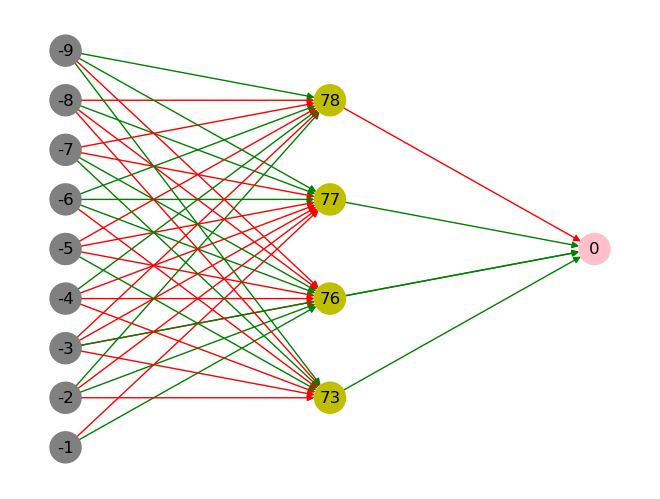

In [92]:
# edges between nodes
for node in list_of_nodes:
    G.add_edge(node[0], node[1], weight=node[2])

# positions of the nodes
pos = nx.get_node_attributes(G, 'pos')

# color the arrows
edge_colors = ['r' if G[u][v]['weight'] < 0 else 'g' for u,v in G.edges()]
# green for input nodes, yellow for hidden nodes, red for output nodes
node_colors = ['gray' if node < 0 else 'y' if node > 0 else 'pink' for node in G.nodes()]

# weights of the edges
weights = nx.get_edge_attributes(G, 'weight')
# draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, node_size=500, arrows=True)
# draw the weights
plt.show()